In [7]:
# Boilerplate code
from IPython.display import HTML, display
from IPython.display import Image
from helper import hide_toggle

import matplotlib.pyplot as plt
import numpy as np

import tensorsignatures as ts
data = ts.TensorSignatureData(
    seed=573, 
    rank=5, 
    samples=100, 
    dimensions=[3, 5],
    mutations=1000)
snv = data.snv()

%matplotlib inline
%config InlineBackend.figure_format='retina'

hide_toggle()

# Understanding Tensor factors


In the previous section, we created a simulated dataset using the `TensorSignaturesData` class, and investigated the data by plotting mutational spectra in various genomic contexts. While doing so, we discovered that some variant types occur with different frequencies in different genomic states, for example, frequencies of coding strand C>A, C>T and T>A variants seemed to be twice as large in comparison to corresponding numbers on template strand DNA. Strand asymmetries have been observed for several mutational processes and are often attributed to DNA repair mechanisms. Transcription coupled repair (TCR), for example, actively depletes mutations on template strand DNA in gene encoding regions.


## Transcriptional and replicational biases

TensorSignatures models variability in mutagenesis due to transcription and replication by

1. extracting separate single base substitution spectra for coding and template strand, and leading and lagging strand DNA
2. fitting a scalar for each signature in context of transcription and replication that quantifies the overall strand asymmetry of single base substitutions (bias matrix `b`)
3. fitting a scalar for each signature that is interpreted as the relative signature activity of signature in transcribed vs untranscribed regions, and early and late replicating regions (activity matrix `a`).

To understand this better, let us first plot the signatures that were used to simulate the counts in data.

In [8]:
snv = data.snv()

In [11]:
snv[:,:,:,0].sum(axis=(0,1,2,4)).shape

(96,)

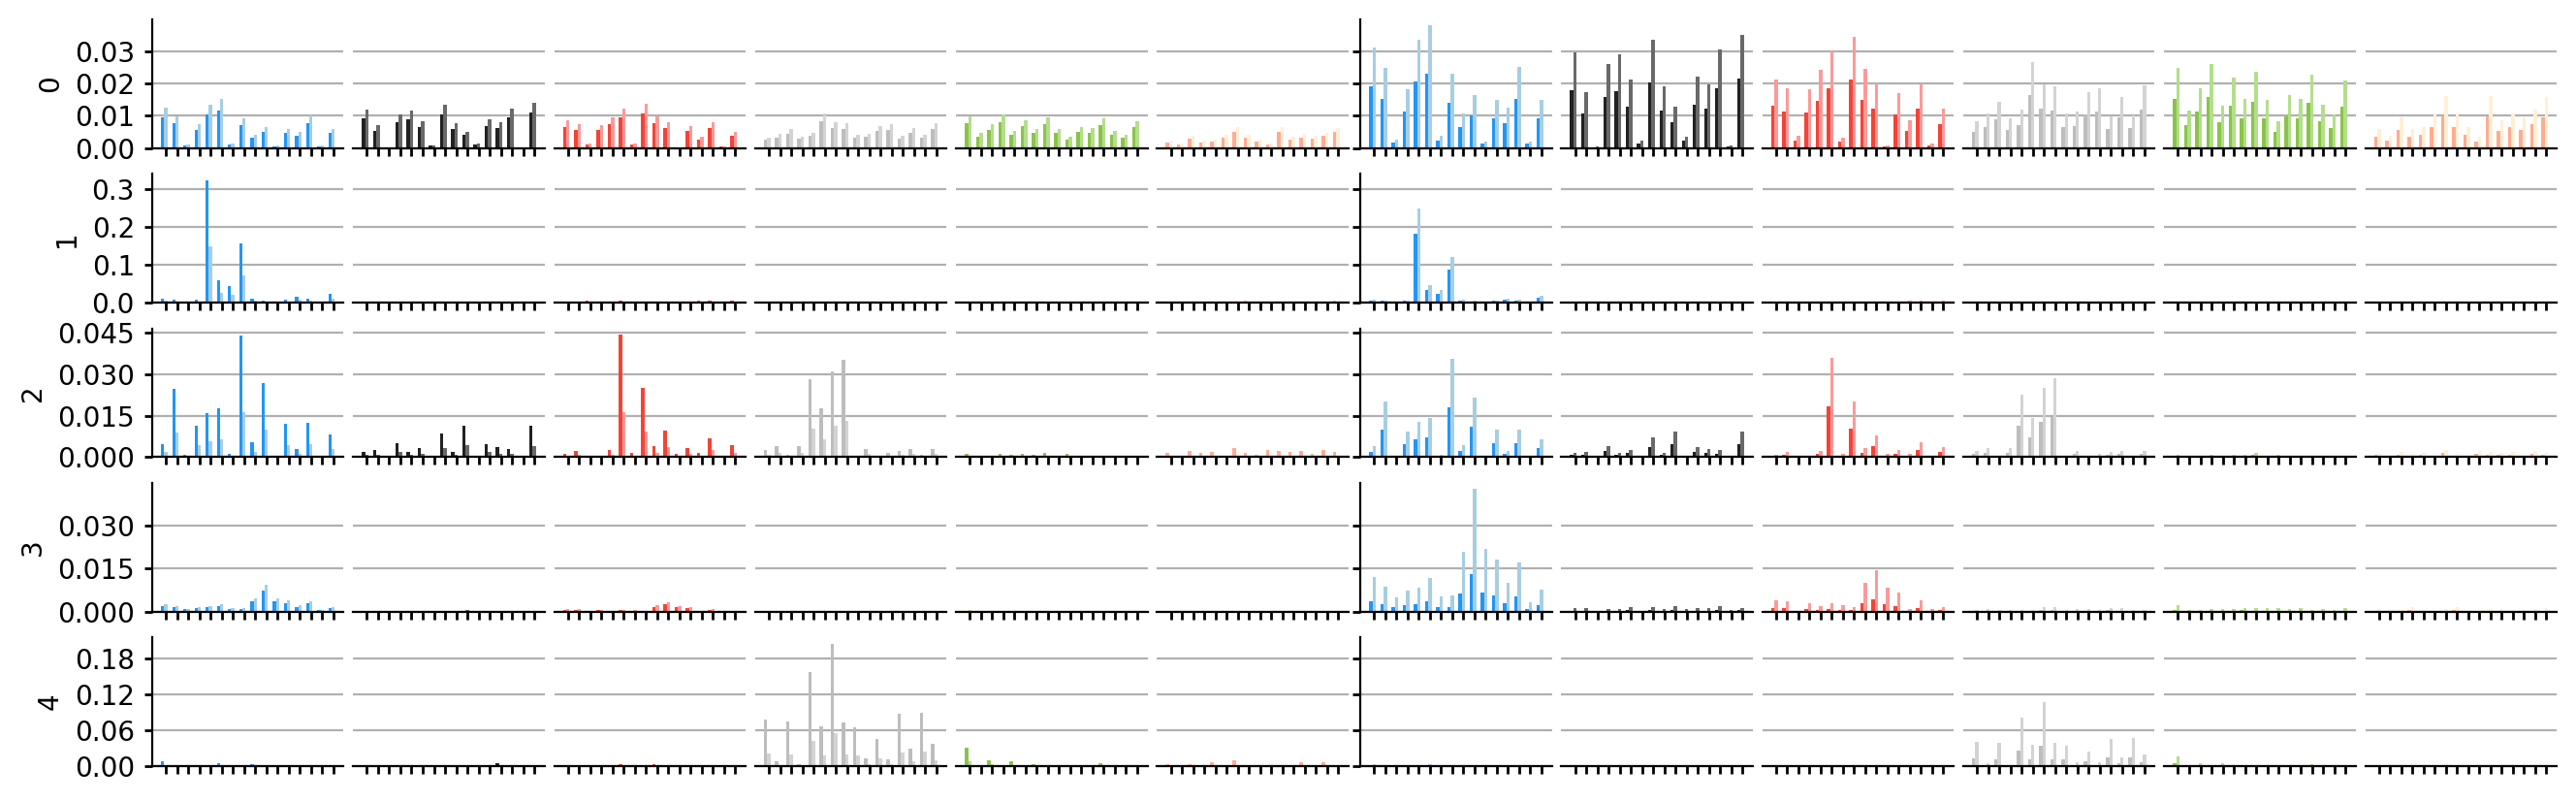

In [2]:
plt.figure(figsize=(16, 5))
ts.plot_signatures(data.S.reshape(3,3,-1,96,data.rank))

This reveals the SNV spectra (rows) in context of transcription and replication in the left and right column. Colors indicate the mutation type (blue C>A, black C>G, red C>T, grey T>A, green T>C and salmon T>G), while the shading indicates the mutation type probabilities for coding strand and leading strand DNA (dark), and for template and lagging strand DNA (light), respectively. Notice, for example, how in the fourth signature (last row), the amplitude of dark and light grey bars differ, indicating that this mutational process is more likely to produce T>A mutations on coding and leading strand DNA respectively.

TensorSignatures models the propensity of a mutational process to generate strand specific mutations by scaling the SNV spectra for coding and template, and leading and lagging strand with a multiplicative scalar variable. To visualise the strand biases for our simulated dataset, we pass the strand biases, accessible via the b attribute of our data object, to the ts.heatmap function.

(<matplotlib.image.AxesImage at 0x7f1311567fd0>,
 <matplotlib.colorbar.Colorbar at 0x7f1313baa5f8>)

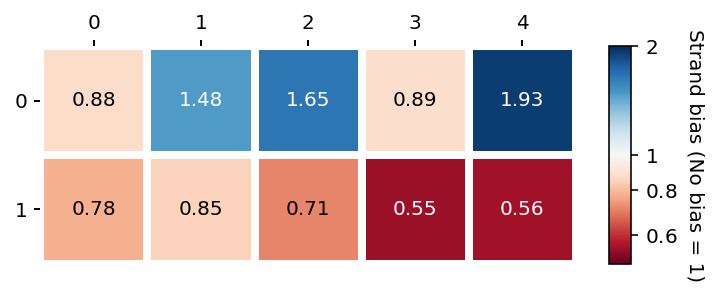

In [3]:
plt.figure(figsize=(6,2))
ts.heatmap(
    data.b,
    vmin=.5, vmax=2, # allows to specify the limits of the colorbar row_labels=[’transcription’, ’replication’],
    cbarlabel="Strand bias (No bias = 1)" # color bar label
)

Rows of the heat map depict the context and columns signatures. Note the logarithmic scaling of the color bar, which indicates that a baseline value of 1 resembles a mutational process with no strand preference. Coefficients < 1 (red) indicate signature enrichment on template or lagging strand DNA, and conversely, values > 1 (blue), an asymmetry towards the on coding or leading strand.

## Signatures activities in specific genomic regions


The multidimensional representation of SNV count data allows TensorSignatures to quantify the propensity of mutational processes within confined genomic regions. These genomic contexts, thereafter also genomic states, may represent genomic features such as specific chromatin marks or nucleosome occupancy. To illustrate this, we depicted a genomic region in the Fig. A.1 together with arbitrary genomic states and respective mutations. 

In [4]:
Image(url= "https://tensorsignatures.readthedocs.io/en/latest/_images/genomic_states.png")

*Fig. A.1 The distribution of single base substitutions may vary due to differences in genome organisation and other factors. The horizontal bar plot in the upper panel depicts genomic states, which represent confined genomic regions with certain features. The rainfall plot underneath shows the variant types at these genomic loci.*

The rainfall plot representation may not always reveal changes in the mutational spectrum on first sight. However, the SNV count tensor contains the mutational spectra of each state combination. We can inspect them by indexing the respective state and summing over all remaining dimensions except the one for trinucleotides. To visualize, for example, pooled mutation spectra along the five states of the fourth dimension in our simulated dataset we would execute the following code.


Text(0.5, 1.0, 'Genomic state 4')

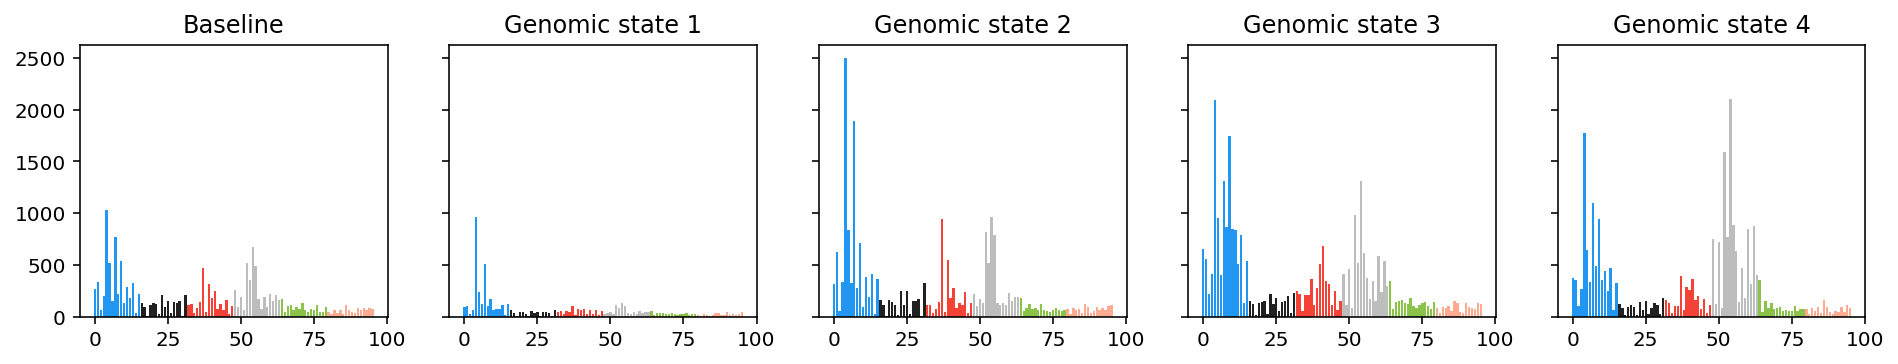

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(16, 2.5), sharey=True)
ax[0].bar(np.arange(96), snv[:,:,:,0].sum(axis=(0,1,2,4)), color=ts.DARK_PALETTE)
ax[0].set_title('Baseline')
ax[1].bar(np.arange(96), snv[:,:,:,1].sum(axis=(0,1,2,4)), color=ts.DARK_PALETTE)
ax[1].set_title('Genomic state 1')
ax[2].bar(np.arange(96), snv[:,:,:,2].sum(axis=(0,1,2,4)), color=ts.DARK_PALETTE)
ax[2].set_title('Genomic state 2')
ax[3].bar(np.arange(96), snv[:,:,:,3].sum(axis=(0,1,2,4)), color=ts.DARK_PALETTE)
ax[3].set_title('Genomic state 3')
ax[4].bar(np.arange(96), snv[:,:,:,4].sum(axis=(0,1,2,4)), color=ts.DARK_PALETTE)
ax[4].set_title('Genomic state 4')

his plot nicely illustrates that different genomic states may have a variable exposure to different mutational signatures. For example, judging from the prevalence of C>A and T>A variants in genomic state 2 and 4, it appears likely that these states are dominated by signature 3 and 4 respectively. TensorSignatures models the activity of each signature by fitting a single coefficient for each signature and genomic state. To visualize the coefficients used to generate our simulated dataset we execute

(<matplotlib.image.AxesImage at 0x7f13114f4668>,
 <matplotlib.colorbar.Colorbar at 0x7f13114fb358>)

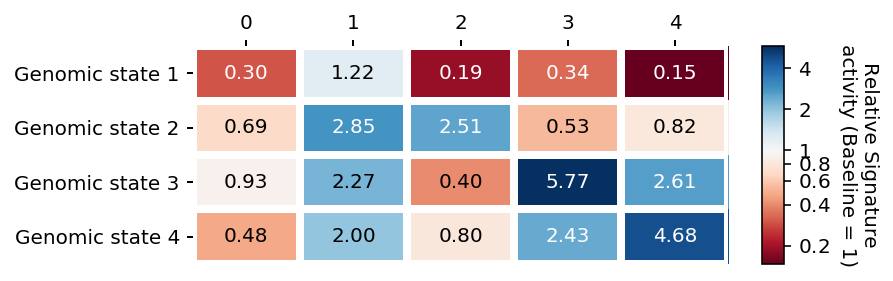

In [6]:
plt.figure(figsize=(6,2))
ts.heatmap(data.k1,
           row_labels=['Genomic state 1', 'Genomic state 2', 'Genomic state 3', 'Genomic state 4', ],
           col_labels=['{}'.format(i) for i in range(5)],
           cbarlabel='Relative Signature\nactivity (Baseline = 1)' # color bar label
          )

which confirms our suspicion about the elevated activities of signature 3 and 4 in genomic state 3 and 4 respectively. To interprete this correctly, keep in mind that usually majority of SNVs do not fall into specific genomic states and therefore end up in the baseline or “unassigned” state, which is in TensorSignatures always 1, and to which all other coefficients are inferred relatively to. In other words, signature 3, for example, shows 5.77 times higher activities in genomic state 3 in comparison to the genomic baseline.